```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\envs\slab\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_221215'
expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in C:\_Data\LLqub


In [5]:
config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be c:\_Lib\python\rfsoc\example_expts\config_zcu216_LLStdCandle.yml


# Qubit/resonator to probe

In [428]:
qubit_i = 0

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [12]:
# im = InstrumentManager(ns_address='192.168.14.1')
im = InstrumentManager(ns_address='192.168.137.1')

In [18]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [13]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

# RFSoC Calibration

In [15]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [3748.2, 3734.2, 3694.4, 3502.3, 3406.3, 3247.2], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 200, 'frequency': [7088.8, 7112.3, 7133.9, 7163.0, 7205.0, 7225.2], 'gain': 5000, 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [10, 10, 10, 10], 'relax_delay': 0.1}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'pulse_length': 0.5, 'readout_length': 1.0, 'trig_offset': 0, 'gain': 5000, 'frequency': 7088.8, 'reps': 500, 'qubit': 0}}
215 307
readout freq 

  0%|          | 0/500 [00:00<?, ?it/s]

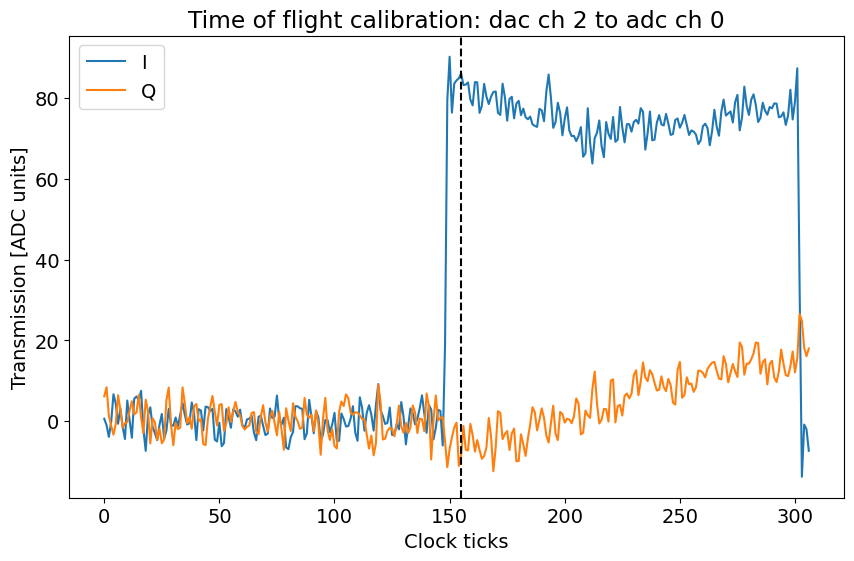

In [18]:
tof.display(adc_trig_offset=155)

In [131]:
tof.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_adc_trig_offset_calibration_qubit1.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [431]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 3.0# MHz
npts = 150
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=500, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain = 800

rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rspec.cfg.device.readout.readout_length = 10
print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50, 50, 50, 50], 'f_ge': [3604.845498259358, 3587.806133603062, 3564.622783862901, 3366.048410721531, 3284.839864934618, 3107.9173867360864], 'f_ef': [3437.991481304768, 3300, 3200, 3100, 3000, 2900], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [21513, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.06, 7135.48, 7175.62, 7206.24, 7229.93], 'gain': [1500, 1000, 1000, 1000, 500, 500], 'readout_length': 10, 'relax_delay': 5}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': [2, 2, 2, 1, 1, 1]}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 7088.32, 'step': 0.02, 'expts': 150, 'reps': 500, 'pulse_e': False, 'pulse_f': False,

  0%|          | 0/150 [00:00<?, ?it/s]

[7089.8099999999995, 5000, 1000, 0, 127.20696958654335, 143.43061786205516, 1.49995714425325]
[ 7.08984475e+03  9.11972142e+04  2.34988668e+04 -2.28625721e-01
  1.60110909e+02  3.33708925e+01 -8.48531949e-01]

Freq with minimum transmission: 7089.78
Freq with maximum transmission: 7090.799999999999
From fit:
	f0: 7089.844747737138
	Qi: 91197.21422696006
	Qe: 23498.86675173276
	Q0: 18684.432519073376
	kappa [MHz]: 0.37945197107269424
	phi [radians]: -0.22862572100138123


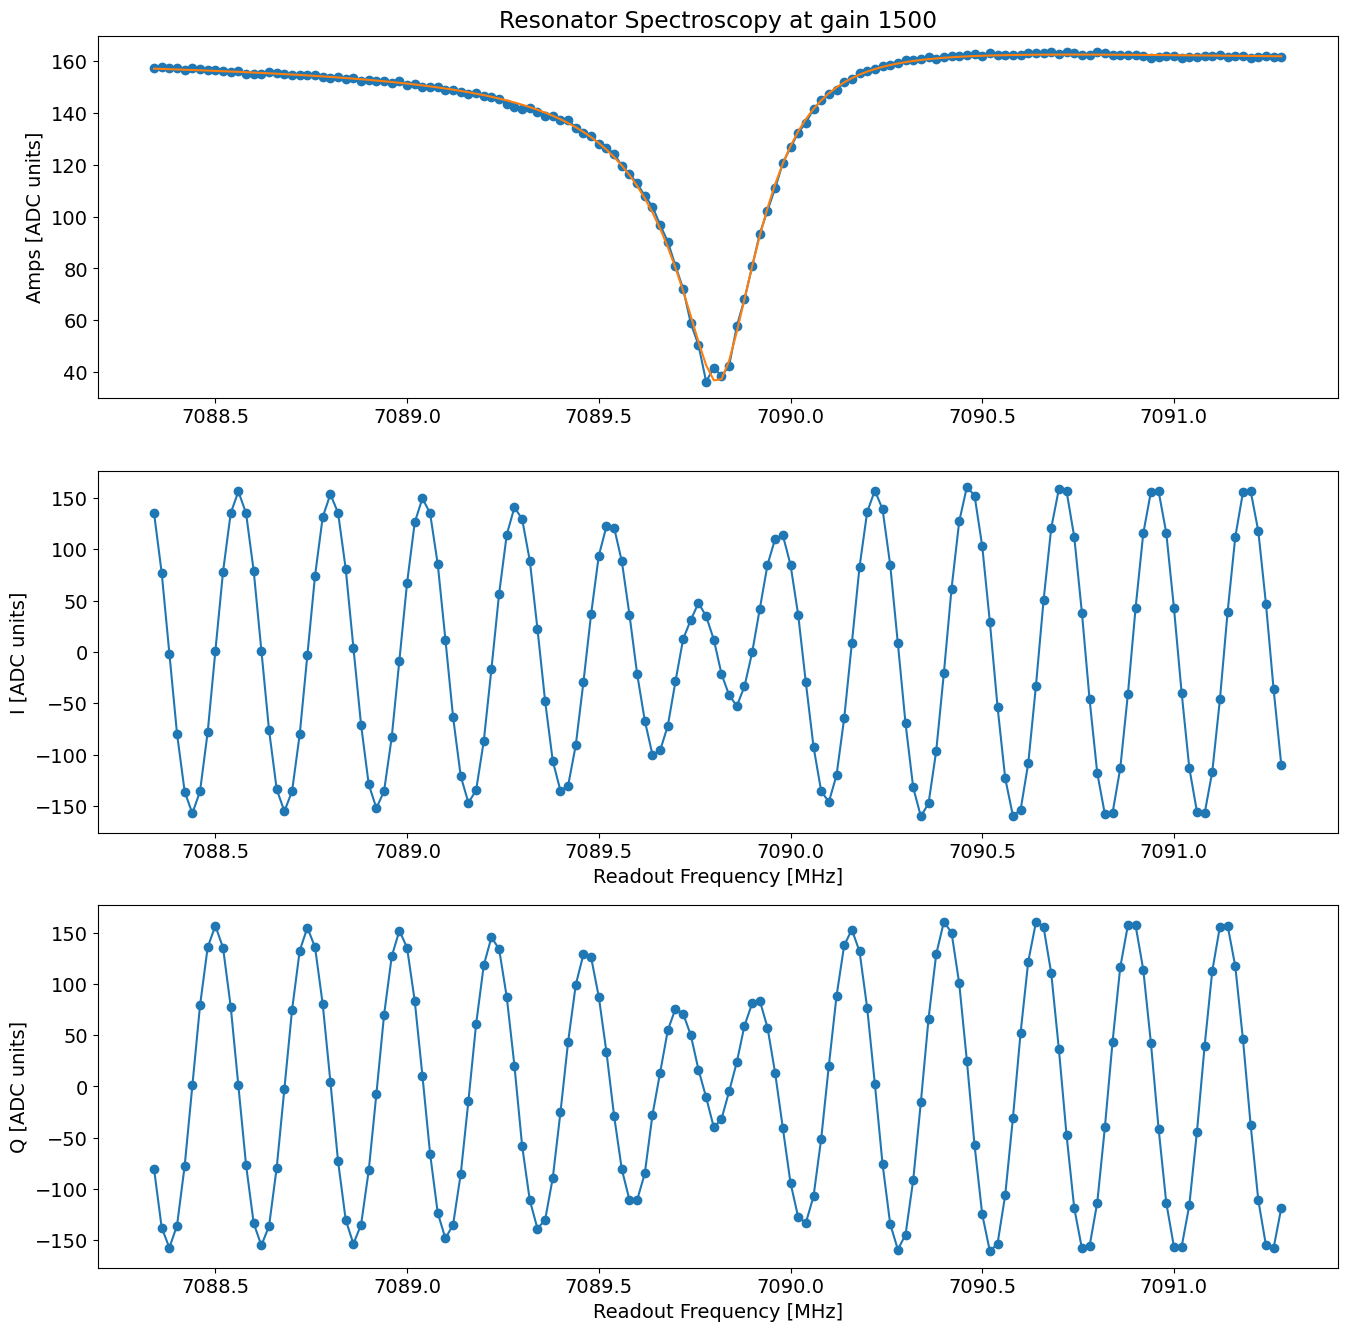

In [432]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [36]:
rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_resonator_spectroscopy_qubit3.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [ ]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2.5
npts_f = 150

span_gain = 0.9
npts_gain = 10

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0.005,
    step_gain=span_gain/npts_gain, # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=2000, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

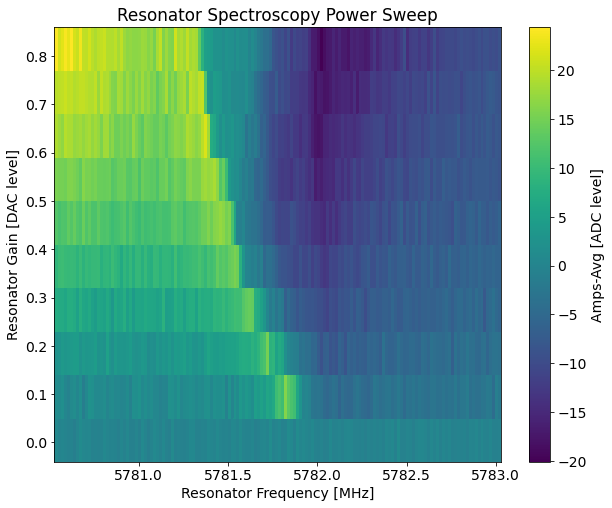

In [ ]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [297]:
rpowspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_power_sweep_resonator_spectroscopy_qubit1.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [438]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2
npts = 250

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.95*span, # resonator frequency to be mixed up [MHz]
    # start=3440,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=100, # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50, 50, 50, 50], 'f_ge': [3604.845498259358, 3587.806133603062, 3564.622783862901, 3366.048410721531, 3284.839864934618, 3107.9173867360864], 'f_ef': [3437.991481304768, 3300, 3200, 3100, 3000, 2900], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [21513, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.06, 7135.48, 7175.62, 7206.24, 7229.93], 'gain': [1500, 1000, 1000, 1000, 500, 500], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': 50}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': [2, 2, 2, 1, 1, 1]}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 3603.845498259358, 'step': 0.008, 'expts': 250, 'reps': 100, 'rounds

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3604.758266100011, HWHM 0.04066487346716063
Found peak in I at [MHz] 3604.7575496191275, HWHM 0.042436459624866
Found peak in Q at [MHz] 3604.758644858144, HWHM 0.040783630686355994


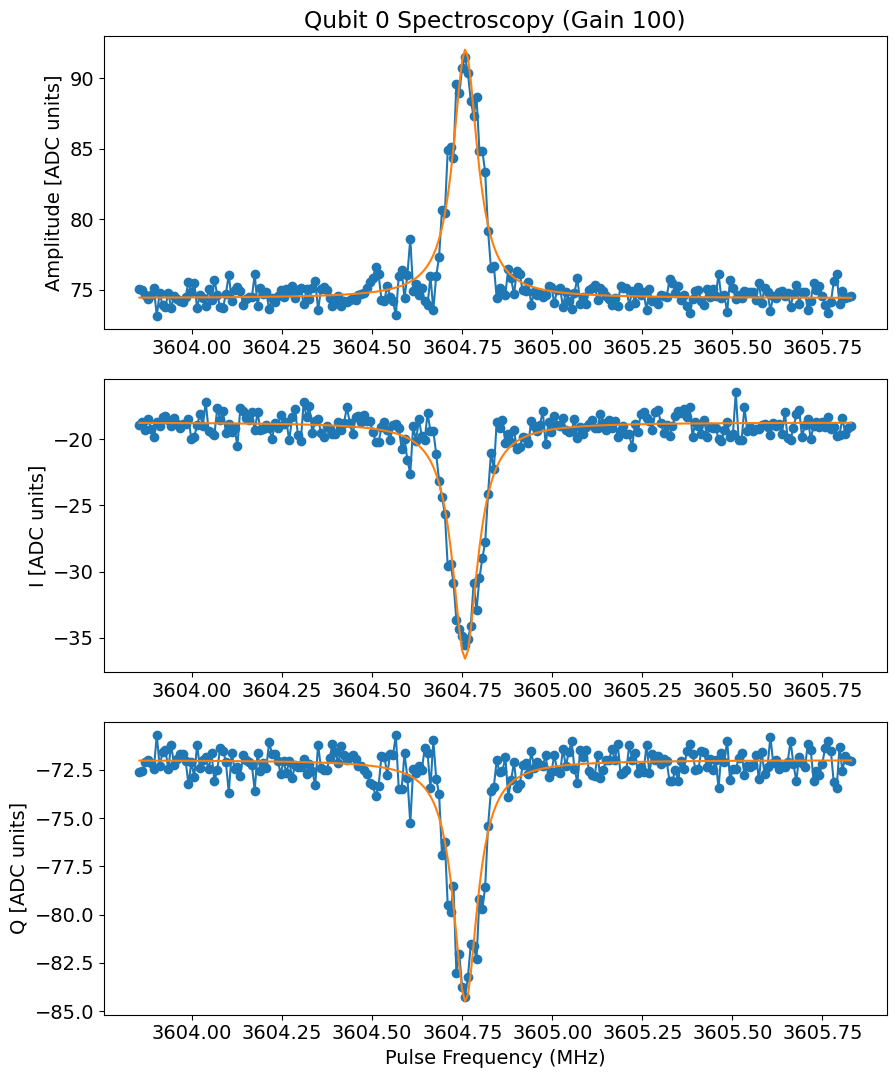

In [439]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [270]:
qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_spectroscopy_qubit0.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [28]:
soc.cycles2us(5*50)

0.7142928572142864

In [141]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=32000, # qubit gain [DAC units],
    # gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [3604.8, 3734.2, 3694.4, 3502.3, 3406.3, 3247.2], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7115.5, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1000, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [10, 10, 10, 10], 'relax_delay': 100}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 0.0023251488095238095, 'expts': 101, 'reps': 1000, 'gain': 32000, 'pulse_type': 'gauss', '

  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.8801713607224584
Pi length from avgi data [us]: 0.1123300379054675
	Pi/2 length from avgi data [us]: 0.05616501895273375

Decay from avgq [us] 0.8262172884667096
Pi length from avgq data [us]: 0.11231654082082906
Pi/2 length from avgq data [us]: 0.05615827041041453


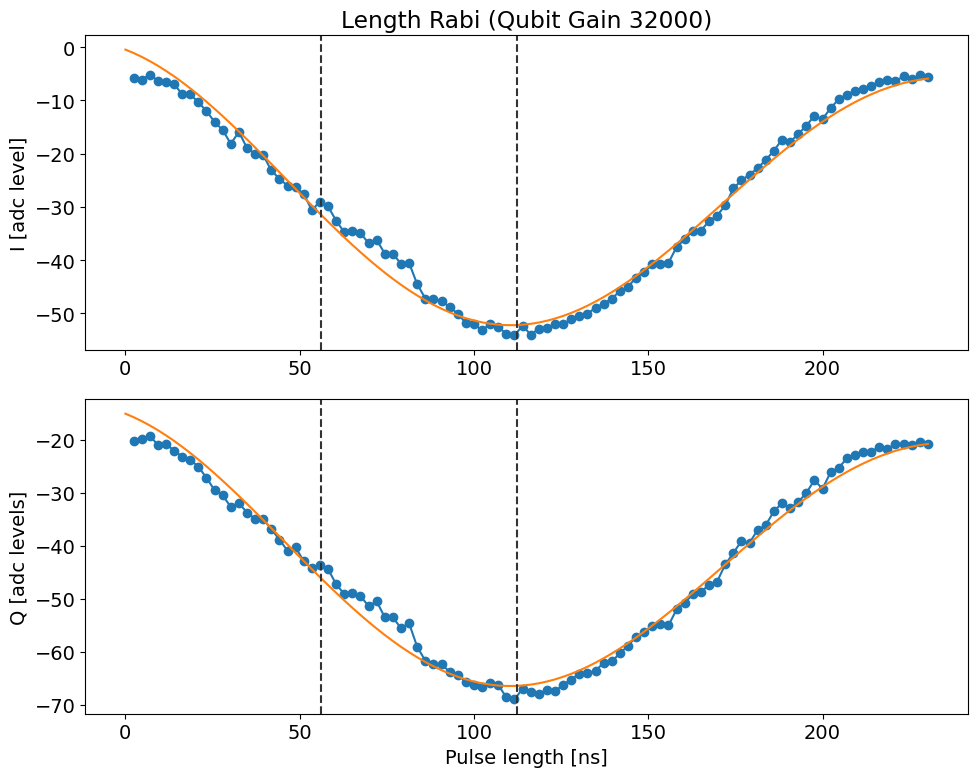

In [142]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [273]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_length_rabi_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_length_rabi_qubit0.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [304]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.025, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

amprabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50], 'f_ge': [3604.845498259358, 3590, 3544, 3350, 3250, 3100], 'f_ef': [3276.5254218804166, 3200, 3100, 3000, 2900, 2800], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [23400, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.0, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1000, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 316, 'expts': 101, 'reps': 100, 'rounds'

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0009177215189873418, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Pi gain from avgi data [dac units]: 27117
	Pi/2 gain from avgi data [dac units]: 13558
Pi gain from avgq data [dac units]: 27543
	Pi/2 gain from avgq data [dac units]: 13771


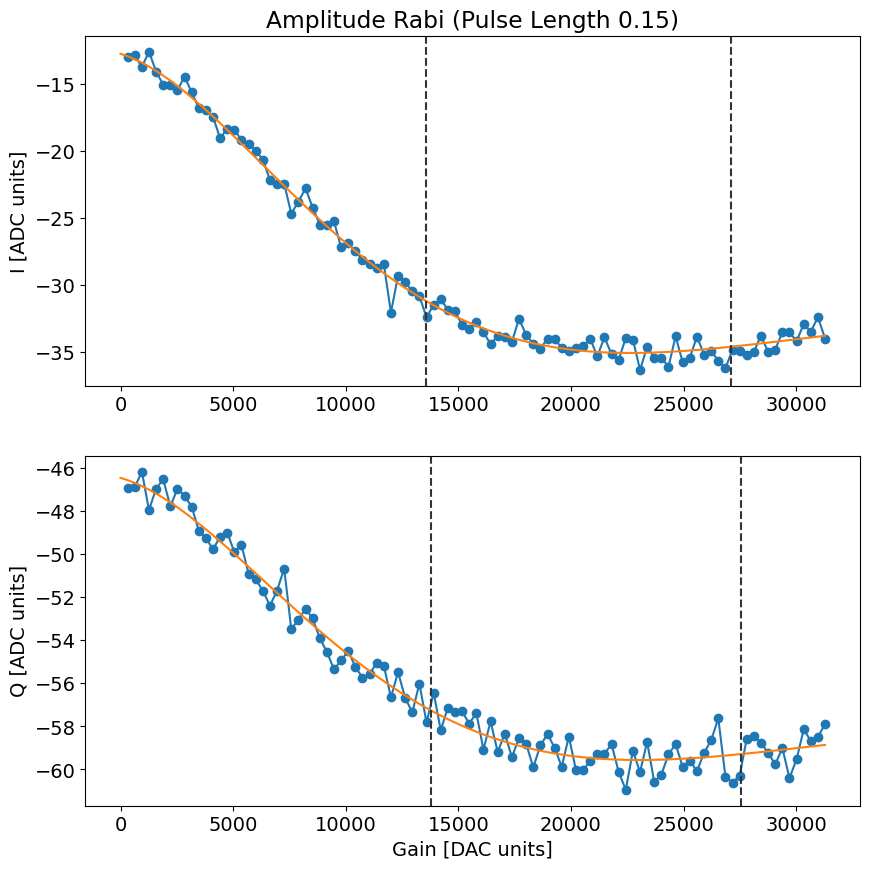

In [305]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 3

span_f = 5
npts_f = 5

amprabichev.cfg.expt = dict(
    start_f=4315,
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [443]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=20000,
    check_f=True,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=7089.82 - 0.2
# shot.cfg.device.readout.gain=1500
# shot.cfg.device.readout.readout_length = 2 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50, 50, 50, 50], 'f_ge': [3604.845498259358, 3587.806133603062, 3564.622783862901, 3366.048410721531, 3284.839864934618, 3107.9173867360864], 'f_ef': [3437.991481304768, 3300, 3200, 3100, 3000, 2900], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [21513, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.06, 7135.48, 7175.62, 7206.24, 7229.93], 'gain': [1500, 1000, 1000, 1000, 500, 500], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': [100, 100, 100, 100, 100, 100]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': [2, 2, 2, 1, 1, 1]}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'reps': 20000, 'check_f': True, 'qubit': 0}}


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Unrotated:
Ig -18.80081300813008 +/- 20.46509318505704 	 Qg -72.3219512195122 +/- 20.8058220087413 	 Amp g 74.72573317113842
Ie -54.27479674796748 +/- 29.56995598398942 	 Qe -95.3130081300813 +/- 25.628555007025202 	 Amp e 109.6828294713358
If -47.59674796747967 +/- 27.21821560972875 	 Qf -118.30731707317074 +/- 36.53269311231266 	 Amp f 127.52282811375984
Rotated:
Ig 71.12640411107898 +/- 20.46509318505704 	 Qg 22.3647764469233 +/- 20.8058220087413 	 Amp g 74.55969814379192
Ie 111.48871263403348 +/- 29.56995598398942 	 Qe 6.43001179850482 +/- 25.628555007025202 	 Amp e 111.67398128715125
If 128.9723839127618 +/- 27.21821560972875 	 Qf 21.860103885662006 +/- 36.53269311231266 	 Amp f 130.81184944045688


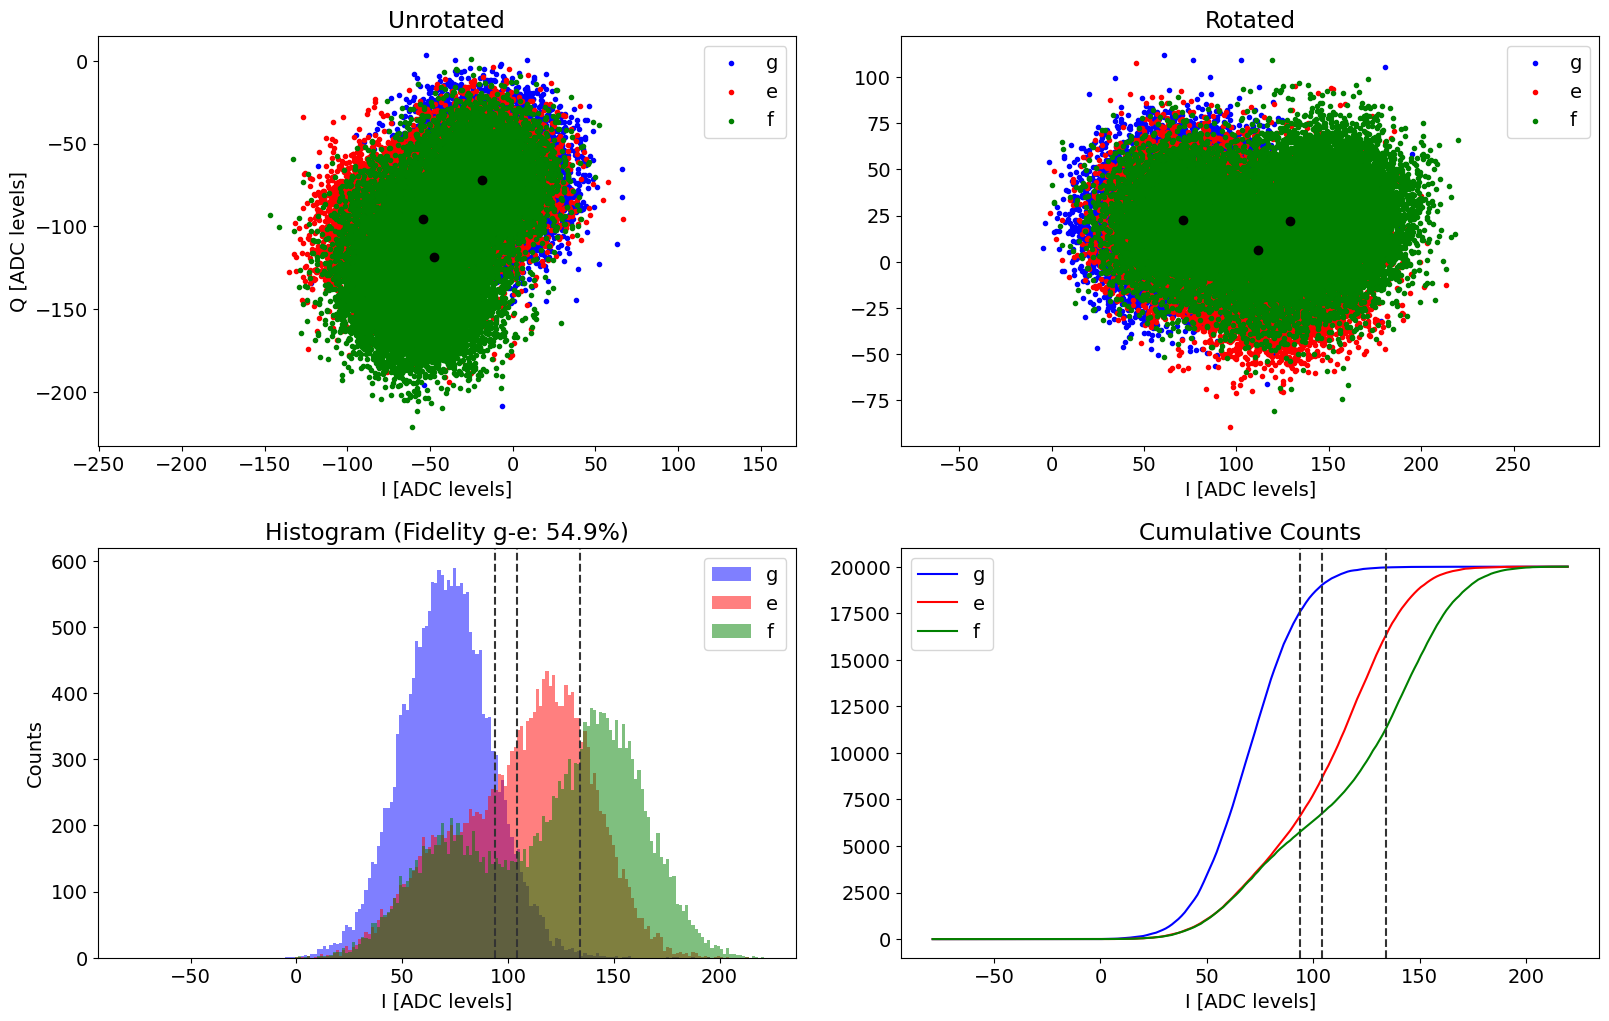

ge fidelity (%): 54.910000000000004
gf fidelity (%): 61.31999999999999
ef fidelity (%): 25.069999999999997
rotation angle (deg): 122.05470777724754
threshold ge: 93.62640411107898
threshold gf: 104.12640411107898
threshold ef: 134.12640411107898


In [444]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True, span=150, plot_f=True)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [126]:
shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_single_shot_qubit1.h5


### Single shot/readout optimization

In [57]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1 # MHz
npts_f = 5

span_gain = 0.07
# npts_gain = 2
npts_gain = 7

span_len = 9 # us
# npts_len = 2
npts_len = 3

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.0555447534924, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 126.826, 0], 'threshold_ge': [0, 0, 5.5435, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'i

  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
shotopt.analyze()
print(shotopt.data['fid'])

(4, 6, 2)
[-805.55554475 -805.35554475 -805.15554475 -804.95554475 -804.75554475]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07]
[3. 6. 9.]
Max fidelity 0.14115141151411514
Set params: 
 angle (deg) 79.27975364474388 
 threshold -74.77681231100001 
 freq [Mhz] -804.7555447534925 
 gain [dac units] 0.06999999999999999 
 readout length [us] 9.0
[[[0.00840008 0.01332007 0.00761008]
  [0.0196801  0.0201102  0.02307012]
  [0.03011015 0.02903029 0.02637013]
  [0.03112016 0.03297016 0.03285016]
  [0.03341017 0.03753019 0.04184021]
  [0.03855039 0.03842019 0.03890039]
  [0.04129021 0.04111021 0.03618018]]

 [[0.03064015 0.03299016 0.03118016]
  [0.03923039 0.04150042 0.04435044]
  [0.04181042 0.04555023 0.04756024]
  [0.04568023 0.05172026 0.04778024]
  [0.05450027 0.06252031 0.05771087]
  [0.0604203  0.05873059 0.06262031]
  [0.06284031 0.05775029 0.06450032]]

 [[0.04171021 0.04239021 0.04251021]
  [0.07371074 0.08122081 0.08335083]
  [0.06460032 0.06747034 0.06370032]
  [0.05880029 0.05490027 0.05565

In [59]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [175]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 100
npts = 100

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = 200 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [3604.8, 3590, 3544, 3350, 3250, 3100], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7115.5, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1000, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': 200}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 1.0, 'expts': 100, 'reps': 100, 'rounds': 10, 'qubit': 0}}


  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 avgi [us]: 45.1881476847847
Fit T1 avgq [us]: 48.66166623180099


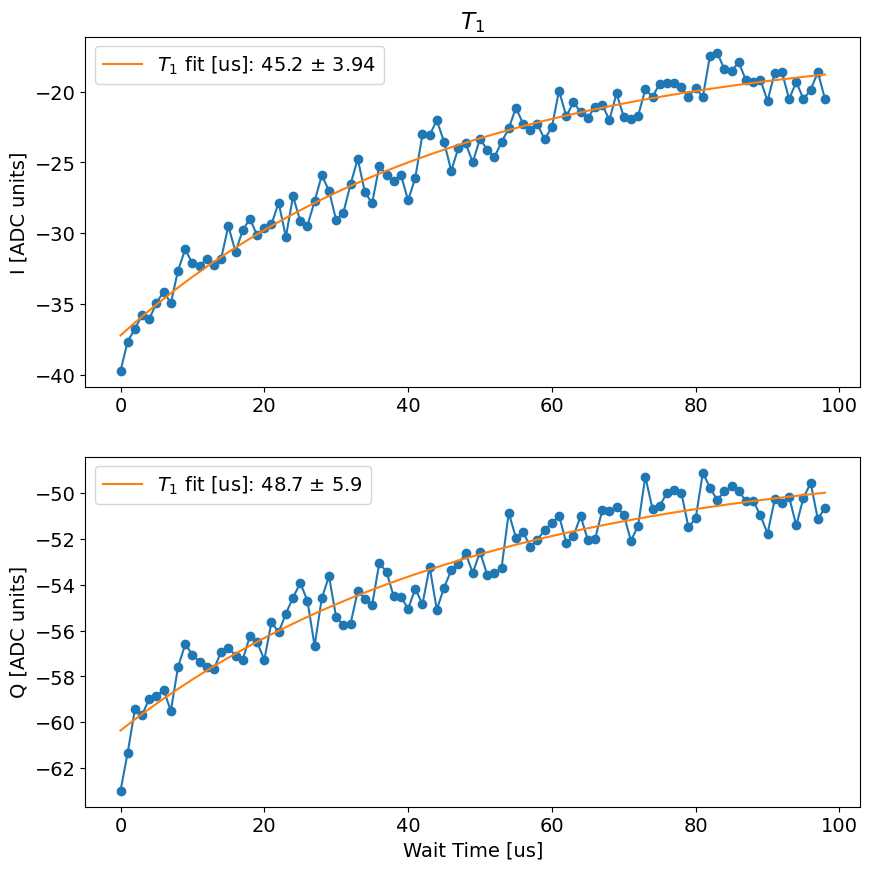

In [176]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [303]:
t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_t1_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_t1_qubit0.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [184]:
0.5/soc.cycles2us(50)

4.3008

In [190]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=201,
    ramsey_freq=1.0, # [MHz]
    reps=200,
    rounds=10,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [45.2, 50, 50, 50], 'f_ge': [3604.848908494249, 3590, 3544, 3350, 3250, 3100], 'f_ef': [4000, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7115.5, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1000, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': 135.60000000000002}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 0.04650297619047619, 'expts': 201, 'ramsey_freq': 1.0, 'reps': 200, '

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.04288, which is out of bounds 0.010806030150753768 to 1.6209045226130652. Instead init to 0.8158552763819095
Attempted to init fitparam 1 to 2.04288, which is out of bounds 0.010806030150753768 to 1.6209045226130652. Instead init to 0.8158552763819095
Current pi pulse frequency: 3604.848908494249
Fit frequency from I [MHz]: 1.003410234891031 +/- 0.0006923281973613787
Suggested new pi pulse frequency from fit I [MHz]:
 	3604.845498259358
 	3602.845498259358
T2 Ramsey from fit I [us]: 11.46585573641197
Fit frequency from Q [MHz]: 1.0040740159470516 +/- 0.0007601398222528098
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3604.844834478302
 	3602.844834478302
T2 Ramsey from fit Q [us]: 11.476215349762862


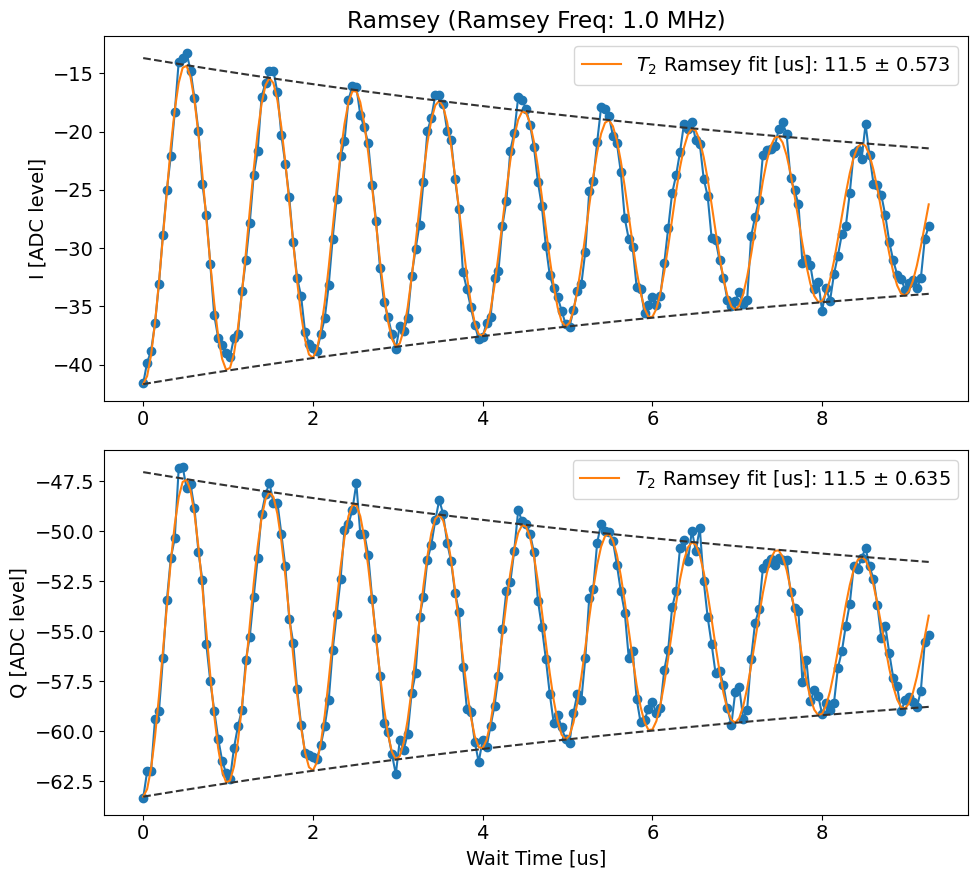

In [191]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True)
t2r.display(fit=True)

In [313]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramsey_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00001_ramsey_qubit0.h5'

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [196]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(100), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=0.100, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50], 'f_ge': [3604.845498259358, 3590, 3544, 3350, 3250, 3100], 'f_ef': [3800, 4000, 4000, 4000], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7115.5, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1000, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': 135.60000000000002}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 0.23251488095238096, 'expts': 151, 'ramsey_freq': 0.1, 'num_pi': 1, '

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 1.9496959999999997, which is out of bounds 0.002886442953020134 to 0.43296644295302006. Instead init to 0.2179264429530201
Attempted to init fitparam 1 to 1.6916479999999998, which is out of bounds 0.002886442953020134 to 0.43296644295302006. Instead init to 0.2179264429530201
Current qubit frequency: 3604.845498259358
Fit frequency from I [MHz]: 0.09951863943143145 +/- 0.00016978902389408197
T2 Echo from fit I [us]: 39.27666561474654
Fit frequency from Q [MHz]: 0.0998786366640973 +/- 0.00024253891830104018
T2 Echo from fit Q [us]: 37.95264495343281


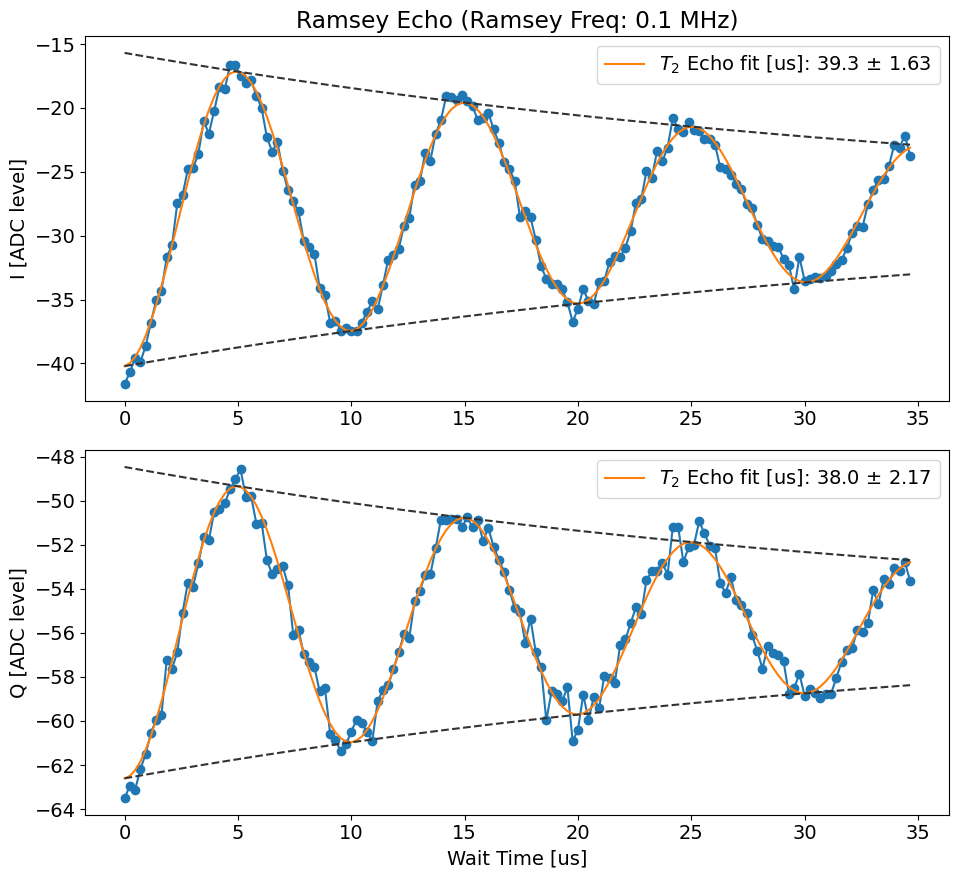

In [197]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [353]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2
npts = 200

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3435,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=5, # ef probe constant pulse length [us]
    gain=200, # ef pulse gain
    qubit=qubit_i,
)

# qEFspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50], 'f_ge': [3604.845498259358, 3590, 3544, 3350, 3250, 3100], 'f_ef': [3437.9905598564555, 3200, 3100, 3000, 2900, 2800], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [23400, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.0, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1500, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 3436.9905598564555, 'step': 0.01, 'expts': 200, 're

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3437.991481304768, HWHM 0.08024202058560043
Found peak in I at [MHz] 3437.9891975426026, HWHM 0.08211992220925703
Found peak in Q at [MHz] 3437.9921258584773, HWHM -0.08010194787603668


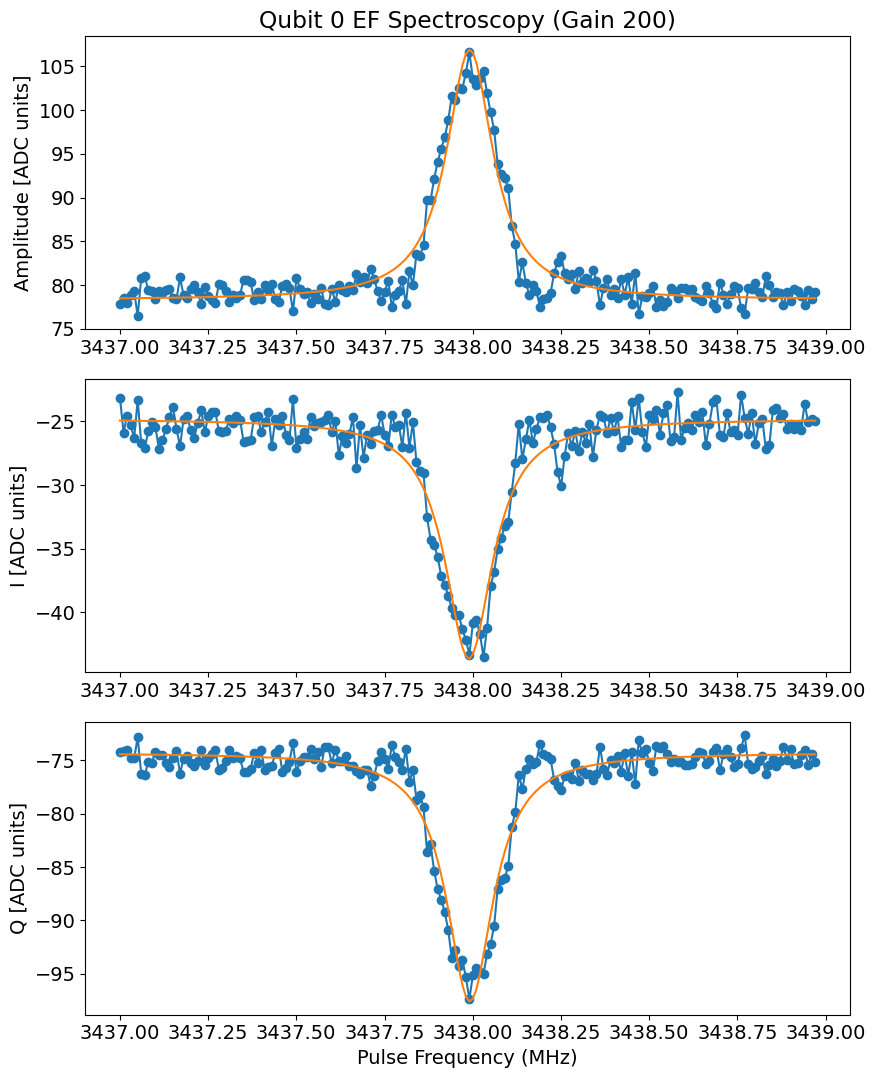

In [354]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [334]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_EF_spectroscopy_qubit0.h5


### Pulse probe EF power sweep

In [21]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

KeyboardInterrupt: 

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [362]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.250, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=True, # set to false when measuring qubit temp
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50], 'f_ge': [3604.845498259358, 3590, 3544, 3350, 3250, 3100], 'f_ef': [3437.991481304768, 3200, 3100, 3000, 2900, 2800], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [23400, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.0, 7134.9, 7172.0, 7205.7, 7228.35], 'gain': [1500, 1000, 1000, 1000, 1000, 1000], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': 2}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 1, 'step': 316, 'expts': 101, 'reps': 100, 'rounds':

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 21513
	Pi/2 gain from avgi data [dac units]: 10756
Pi gain from avgq data [dac units]: 21570
	Pi/2 gain from avgq data [dac units]: 10785


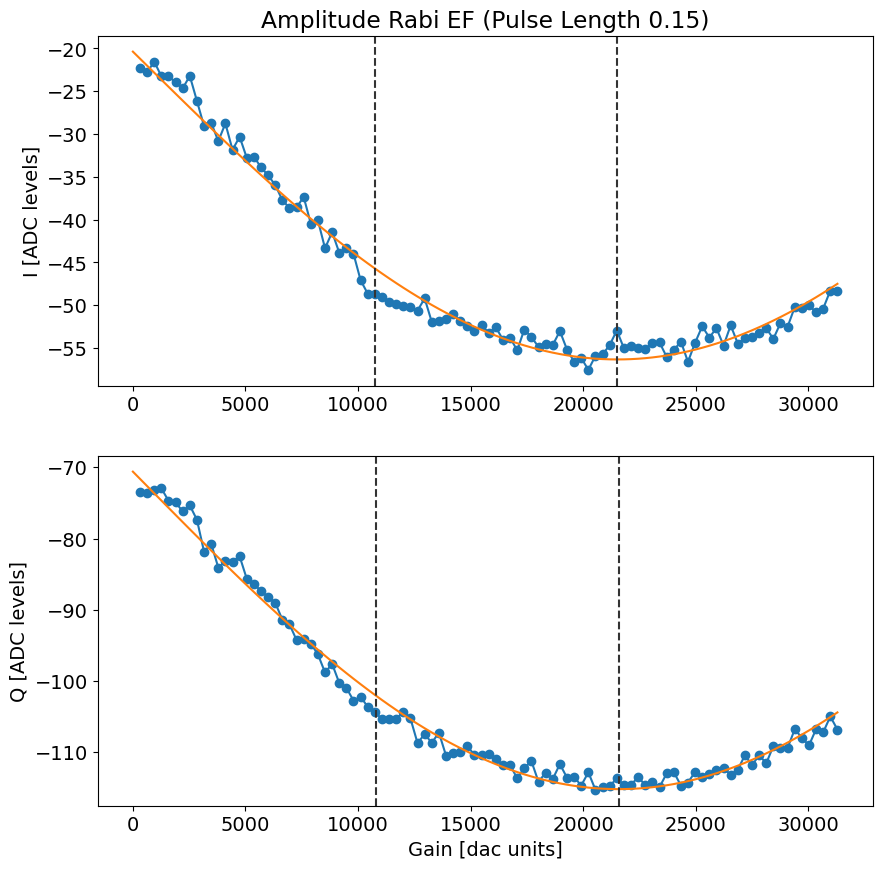

In [363]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [346]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_amp_rabi_EF_qubit0.h5


### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [361]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
if 'mixer_freq' in amprabiEF.cfg.hw.soc.dacs.qubit:
    fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq)
else: fge = 1e6*amprabiEF.cfg.device.qubit.f_ge
kB = 1.380649e-23
################

amps = amprabiEF.data['amps']

print(np.max(amps) - np.min(amps))
efamp_nopulse = 21.31959912361367
efamp_normal = 52.58129746345371

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


52.58129746345371
Qubit temp [mK]: 191.64599497116646


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [447]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=1, # [MHz]
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45.2, 50, 50, 50, 50, 50, 50], 'f_ge': [3604.845498259358, 3587.806133603062, 3564.622783862901, 3366.048410721531, 3284.839864934618, 3107.9173867360864], 'f_ef': [3437.991481304768, 3300, 3200, 3100, 3000, 2900], 'pulses': {'pi_ge': {'gain': [24717, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [21513, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.15, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'frequency': [7089.82, 7117.06, 7135.48, 7175.62, 7206.24, 7229.93], 'gain': [1500, 1000, 1000, 1000, 500, 500], 'readout_length': [2, 2, 2, 2, 2, 2], 'relax_delay': [100, 100, 100, 100, 100, 100]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': 0, 'type': 'full', 'nyquist': [2, 2, 2, 1, 1, 1]}, 'readout': {'ch': 2, 'type': 'full', 'nyquist': 2}}, 'adcs': {'readout': {'ch': 0}}}}, 'aliases': {'soc': 'Qick233'}, 'expt': {'start': 0, 'step': 0.04650297619047619, 'expts':

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.0531457286432158, which is out of bounds 0.01086060606060606 to 1.629090909090909. Instead init to 0.8199757575757575
Attempted to init fitparam 1 to 2.0531457286432158, which is out of bounds 0.01086060606060606 to 1.629090909090909. Instead init to 0.8199757575757575
Current EF frequency: 3437.991481304768
Fit frequency from I [MHz]: 1.0001548295767495
Suggested new EF frequencies from fit avgi [MHz]:
 	3437.9913264751913
 	3435.9913264751913
T2 Ramsey EF from fit avgi [us]: 23.251237706555568
Fit frequency from Q [MHz]: 1.0004442238568099
Suggested new EF frequencies from fit avgq [MHz]:
 	3437.991037080911
 	3435.991037080911
T2 Ramsey EF from fit avgq [us]: 21.707539276050863


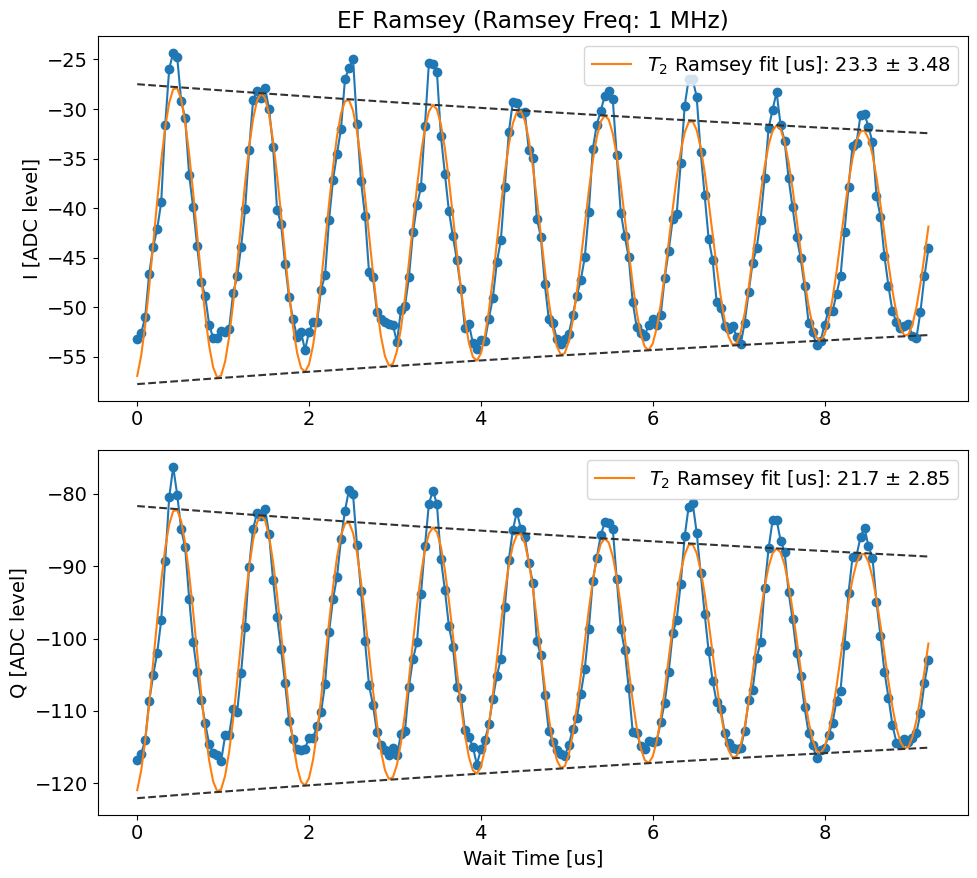

In [448]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [363]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramseyEF_qubit0.h5


# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [28]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 50
npts_f = 150

span_gain = 30000
npts_gain = 5

pump_params=dict(
    ch=4,
    type='full',
    nyquist=1,
)

acspec.cfg.expt = dict(
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=1, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=12, # [us]
    qubit_gain=800,
    qubit_length=10, # [us]
    reps=1000,
    rounds=20, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 10
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4

  0%|          | 0/5 [00:00<?, ?it/s]

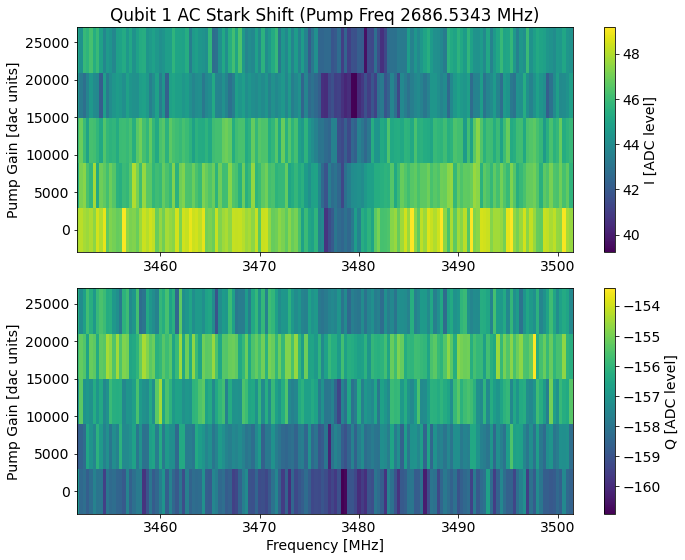

In [29]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

In [30]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_ac_stark_shift_qubit1.h5


# Single qubit RB

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2434148826505, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 15332, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.92, 0.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (0)


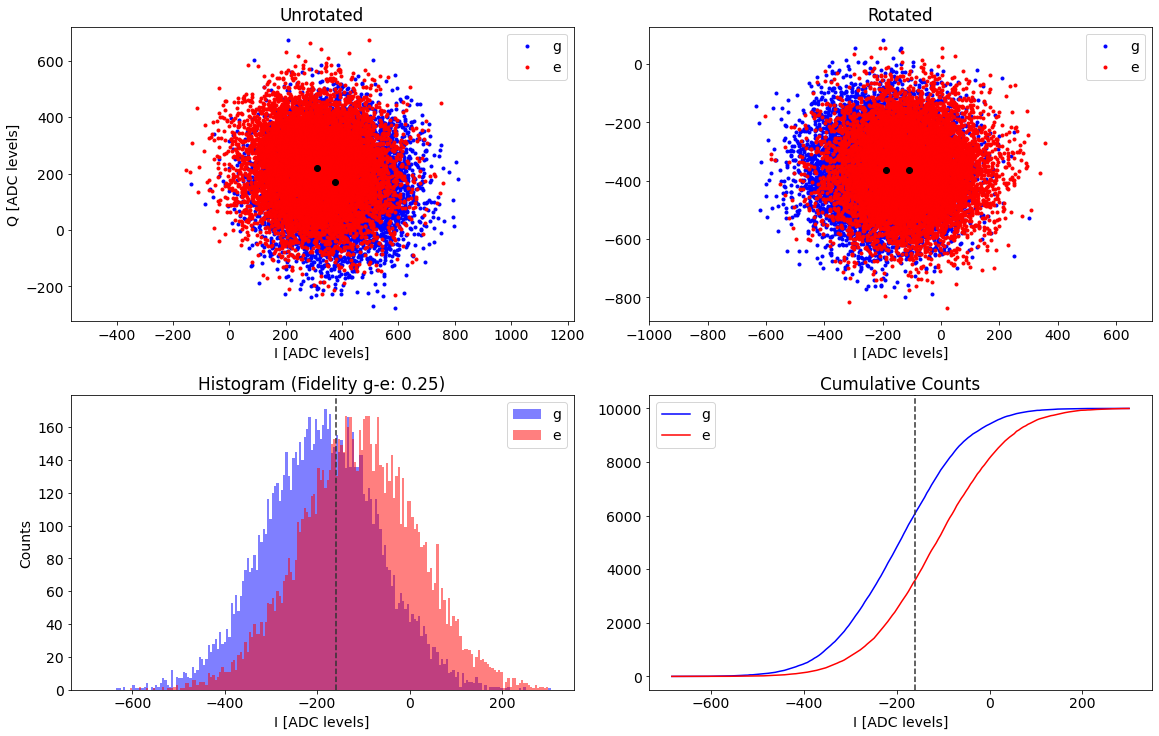

ge fidelity (%): 24.973746061909285 	 angle (deg): -142.06360567273813 	 threshold ge: -159.76791430708363
angles=[-142.06360567273813, 0, 0, 0]
thresholds=[-159.76791430708363, 0, 0, 0]
ge_avgs=[[373.5939400260332, 169.76653198828507, 310.40417552879916, 219.37187510575987], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]


  0%|          | 0/15 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:330: RuntimeWarning: divide by zero encountered in true_divide
  avgi /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:331: RuntimeWarning: divide by zero encountered in true_divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


In [142]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=10, # step rb depth
    expts=15, # number steps
    reps=7000, # number averages per unique sequence
    variations=30, # number different sequences per depth
    # gate_char='X', # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=True, # specifies whether to run RB treating EgGf as the TLS subspace
    qubits=[qubit_i], # the qubits to perform simultaneous RB on
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    # angles=[0, 46.170750588583914, 0, 0],
    # thresholds=[0, 1313.2273024770407, 0, 0],
    # ge_avgs=[[0,0,0,0], [1202.93042968, -519.547555,   1357.15032001, -679.76484953],[0,0,0,0], [0,0,0,0]]
)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

Running regular RB on EgGf subspace
**Depolarizing parameter p: 0.989783402436281
Average RB error: 0.005108298781859477
so average RB fidelity: 0.9948917012181405


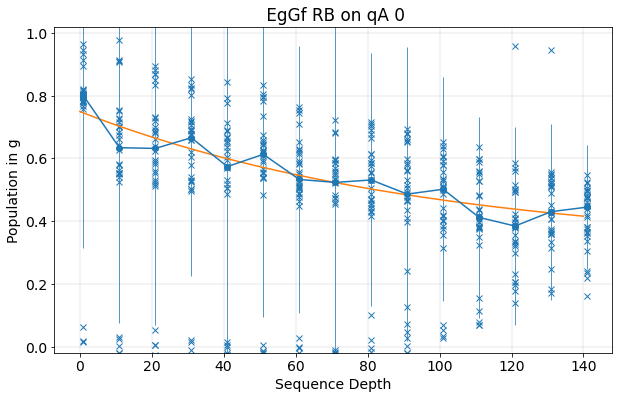

In [143]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=qubit_i)

In [146]:
meas.fitting.rb_gate_fidelity(p_rb=0.989783402436281, p_irb=0.920144, d=2)

0.96482088795141

In [144]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00001_rb1Q_qubit0.h5


In [154]:
class Clifford():
    def xpulse(self):
        print('normal clifford')

    def ypulse(self):
        print('y')
        self.xpulse()

class CliffordEF(Clifford):
    def xefpulse(self):
        print('ef')

class CliffordEgGf(CliffordEF):
    def xpulse(self):
        super().xpulse()
        print('EgGf')

class SimRB(Clifford):
    def clifford(self, flag=None):
        if flag == 'X': self.xpulse()
        elif flag == 'Y': self.ypulse()
    
class RBEgGf(CliffordEgGf, SimRB):
    pass

rbeggf = RBEgGf()
print(RBEgGf.__mro__)
rbeggf.clifford(flag='X')
rbeggf.clifford(flag='Y')

(<class '__main__.RBEgGf'>, <class '__main__.CliffordEgGf'>, <class '__main__.CliffordEF'>, <class '__main__.SimRB'>, <class '__main__.Clifford'>, <class 'object'>)
normal clifford
EgGf
y
normal clifford
EgGf
